# Introduction

For this project, we will be looking at telling stories about data using information about previous winning lottery draws. In theory, the winning ticket in a lottery is completely random and unpredictable, so there shouldn't be anything too interesting. But, that's exactly why I chose this project; it has the potential to reveal something unexpected.

In [3]:
#import a bunch of stuff the usual stuff is here more or less without comment
import bs4 # BeautifulSoup is helpful for collecting the data.
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import r2_score
import requests # Required for collecting Data
import datetime
import matplotlib.pyplot as plt
import re #I added this helps pick the actual numbers out for data collection
import warnings
warnings.filterwarnings('ignore') #prevent warning print outs since
#The comment below was added for reference to get everything else right.
#https://www.lottery.ok.gov/play/draw/check-numbers?gameId=17&drawDate=2021-02-13&lineData=[[1,2,3,4,5,6]]&type=Straight
GAME_IDS = {"MegaMillions" : 17 } #using this dictionary, we could add in other Lottery games, 
#                                  but for simplicity this notebook only looks at one
URL = "https://www.lottery.ok.gov/play/draw/check-numbers"


In [4]:
#Code to winning numbers for the tickets.
pat = re.compile(r"\d{1,2}")
date_class = ["col-6", "col-md-6", "col-sm-3", "text-center"]
def find_nums(soup):
    """Pulls the numbers out of the html doc parsed by BeautifulSoup"""
    l = []
    result = []
    for d in soup.find_all('div'):
        if not d.get('class'):
            continue
        if d.get('class') == ['ball']:
            result.append((d.text))
        if 'special' in d.get('class'):
            result.append(d.text+'s')
    return result
    for d in soup.find_all('div'):
        if d.get('class') == ['ball']:
            l.append(d.text.strip())
        if 'special' in d.get('class'):
            #mark the special ball as special
            l.append(d.text.strip()+'s')
        return l

In [5]:
def find_draw_days(n=100):
    """Calculates the past n days on which there was a draw for the target lottery game.
    MegaMillions draws on Tuesdays and Fridays, so we will generate the dates for those days."""
    next_week = datetime.date.today() + datetime.timedelta(days=7)
    monday = next_week + datetime.timedelta(days=-next_week.weekday()) #first monday after today
    tuesday = monday + datetime.timedelta(days=-6) #last tuesday before monday
    friday = monday + datetime.timedelta(days=-3) #last friday before monday
    mm = []
    for i in range(n):
        mm.append(tuesday + datetime.timedelta(weeks=-i)) 
        mm.append(friday + datetime.timedelta(weeks=-i))
    return mm

In [6]:
#calculate dates and grab data 
draw_days = sorted(find_draw_days(200))

In [7]:
#correctly foormat months for scraping data from the web
def month_format(m):
    if m < 10:
        return '0'+str(m)
    return str(m)
mm_date_strs = list(map(lambda x: str(x.year)+'-'+month_format(x.month)+'-'+month_format(x.day),draw_days))
print(len(mm_date_strs))

400


In [8]:
ses = requests.Session()

In [9]:
#We need to define a few parameters that mean nothing, but we need them inorder to retrieve data from the website.
params = {'lineData' : "[[1, 2, 3, 4, 5, 6]]", 'type' : 1}
params['gameId'] = GAME_IDS['MegaMillions']
draws = []
for date in mm_date_strs:
    params['drawDate'] = date
    req = ses.get(URL, params = params)
    soup = bs4.BeautifulSoup(req.text, "html.parser")
    draws.append([date]+find_nums(soup))

In [10]:
#draws

In [11]:
#clean up draws data before putting it in a DataFrame
ds = list(map(lambda x: x[:6]+[x[6][:-1]], draws[:-1]))
#ds

In [12]:
df = pd.DataFrame(ds)
df.columns = ['date', 'b1','b2','b3','b4','b5','s']
df.head()

,date,b1,b2,b3,b4,b5,s
0,2017-09-26,1,10,57,66,75,4
1,2017-09-29,25,51,62,73,74,7
2,2017-10-03,12,18,19,25,67,7
3,2017-10-06,21,33,36,45,56,12
4,2017-10-10,7,16,24,61,62,2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    399 non-null    object
 1   b1      399 non-null    object
 2   b2      399 non-null    object
 3   b3      399 non-null    object
 4   b4      399 non-null    object
 5   b5      399 non-null    object
 6   s       399 non-null    object
dtypes: object(7)
memory usage: 21.9+ KB


In [14]:
#the data seems clean, but there is an issue with an empty string for some reason, so we'll just remove that row.
pd.unique(df.iloc[114])
df = df[df['s'] != '']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 398
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    398 non-null    object
 1   b1      398 non-null    object
 2   b2      398 non-null    object
 3   b3      398 non-null    object
 4   b4      398 non-null    object
 5   b5      398 non-null    object
 6   s       398 non-null    object
dtypes: object(7)
memory usage: 24.9+ KB


In [16]:
#cast to numeric data
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c])
df.head()
df.date = pd.to_datetime(df.date)

In [17]:
#get basic stats
df.describe()

,b1,b2,b3,b4,b5,s
count,398.00000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,11.29397,23.585427,34.949749,46.364322,58.462312,13.271357
std,8.82557,12.070385,13.054140,12.947888,10.207536,7.089335
min,1.00000,2.000000,4.000000,8.000000,18.000000,1.000000
25%,4.00000,14.000000,26.000000,38.000000,53.000000,7.000000
50%,9.00000,22.000000,34.000000,48.000000,61.000000,13.000000
75%,16.00000,32.000000,44.000000,56.000000,66.750000,19.000000
max,46.00000,59.000000,66.000000,73.000000,75.000000,25.000000


In [18]:
#print list of uniques with counts
print(np.array(np.unique(df[df.columns[1:]], return_counts=True)).transpose())

[[ 1 42]
 [ 2 38]
 [ 3 43]
 [ 4 55]
 [ 5 34]
 [ 6 39]
 [ 7 44]
 [ 8 45]
 [ 9 45]
 [10 63]
 [11 56]
 [12 42]
 [13 41]
 [14 55]
 [15 43]
 [16 39]
 [17 53]
 [18 41]
 [19 43]
 [20 49]
 [21 32]
 [22 51]
 [23 38]
 [24 48]
 [25 50]
 [26 27]
 [27 31]
 [28 33]
 [29 28]
 [30 27]
 [31 40]
 [32 26]
 [33 30]
 [34 35]
 [35 19]
 [36 19]
 [37 31]
 [38 30]
 [39 30]
 [40 22]
 [41 27]
 [42 33]
 [43 34]
 [44 33]
 [45 21]
 [46 33]
 [47 25]
 [48 36]
 [49 24]
 [50 22]
 [51 19]
 [52 25]
 [53 30]
 [54 26]
 [55 21]
 [56 32]
 [57 30]
 [58 31]
 [59 28]
 [60 28]
 [61 25]
 [62 36]
 [63 24]
 [64 31]
 [65 20]
 [66 27]
 [67 24]
 [68 28]
 [69 21]
 [70 33]
 [73  2]
 [74  1]
 [75  1]]


<BarContainer object of 73 artists>

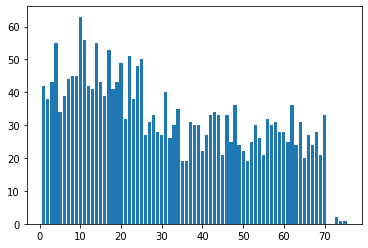

In [19]:
counts = np.array(np.unique(df[df.columns[1:]], return_counts=True))
plt.bar(counts[0], counts[1])

In [20]:
cdf = pd.DataFrame(counts.transpose(), columns=['number', 'count'])
cdf.sort_values('count').tail()

,number,count
16,17,53
3,4,55
13,14,55
10,11,56
9,10,63


In [21]:
cdf['count'].mean()

32.71232876712329

In [26]:
cdf[cdf['count']>cdf['count'].mean()].sort_values('count').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 69 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   number  34 non-null     int64
 1   count   34 non-null     int64
dtypes: int64(2)
memory usage: 816.0 bytes


About half of the possible numbers are more common than average. 10 occurs almost twice the average amount of times.

In [23]:
autos = []
for col in df.columns[1:]:
    autos.append(df[col].autocorr())
autos

[0.06052271725264305,
 0.01476283300079648,
 0.009917608932371647,
 0.01786423977162243,
 0.029184565445418868,
 0.02141693832040247]

In [24]:
df.corr()

,b1,b2,b3,b4,b5,s
b1,1.000000,0.585825,0.412648,0.300276,0.202348,0.122236
b2,0.585825,1.000000,0.737174,0.532643,0.375645,0.128483
b3,0.412648,0.737174,1.000000,0.734479,0.518204,0.010681
b4,0.300276,0.532643,0.734479,1.000000,0.680122,-0.043422
b5,0.202348,0.375645,0.518204,0.680122,1.000000,-0.079361
s,0.122236,0.128483,0.010681,-0.043422,-0.079361,1.000000


There is actual a pretty decent amount of correlation between the 5 normal balls. It is unfortunate that this only holds for balls from the same draws though. For a Time Series model to be useful it needs to predict future values based on the date,time and past values of the data. But, we are going to setup a linear regression model just to see what happens.

In [27]:
df = df[df.columns[:7]]#This is a correction from when I messed up later

In [28]:
from sklearn.linear_model import LinearRegression

df[df.add_suffix('.past').columns[1:]] = df[df.columns[1:7]].shift()
df.head()

,date,b1,b2,b3,b4,b5,s,b1.past,b2.past,b3.past,b4.past,b5.past,s.past
0,2017-09-26,1,10,57,66,75,4,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-09-29,25,51,62,73,74,7,1.0,10.0,57.0,66.0,75.0,4.0
2,2017-10-03,12,18,19,25,67,7,25.0,51.0,62.0,73.0,74.0,7.0
3,2017-10-06,21,33,36,45,56,12,12.0,18.0,19.0,25.0,67.0,7.0
4,2017-10-10,7,16,24,61,62,2,21.0,33.0,36.0,45.0,56.0,12.0


In [29]:
df.dropna(inplace=True)
df.corr()

,b1,b2,b3,b4,b5,s,b1.past,b2.past,b3.past,b4.past,b5.past,s.past
b1,1.000000,0.584449,0.419858,0.306158,0.208168,0.118845,0.060523,-0.006338,-0.004210,0.058209,0.038228,0.033421
b2,0.584449,1.000000,0.745857,0.539383,0.382128,0.125236,-0.013811,0.014763,0.034756,0.061905,0.045303,0.012068
b3,0.419858,0.745857,1.000000,0.732779,0.514854,0.016354,-0.071722,-0.039625,0.009918,0.049259,0.090035,0.019147
b4,0.306158,0.539383,0.732779,1.000000,0.678135,-0.038609,-0.073069,-0.071424,-0.026508,0.017864,0.024041,0.063593
b5,0.208168,0.382128,0.514854,0.678135,1.000000,-0.074417,-0.009781,-0.009328,0.027247,0.028356,0.029185,0.092934
s,0.118845,0.125236,0.016354,-0.038609,-0.074417,1.000000,-0.032107,-0.062537,-0.095339,-0.118693,-0.042752,0.021417
b1.past,0.060523,-0.013811,-0.071722,-0.073069,-0.009781,-0.032107,1.000000,0.585945,0.412594,0.300517,0.202306,0.122101
b2.past,-0.006338,0.014763,-0.039625,-0.071424,-0.009328,-0.062537,0.585945,1.000000,0.737537,0.532577,0.375746,0.128757
b3.past,-0.004210,0.034756,0.009918,-0.026508,0.027247,-0.095339,0.412594,0.737537,1.000000,0.735205,0.518174,0.010244
b4.past,0.058209,0.061905,0.049259,0.017864,0.028356,-0.118693,0.300517,0.532577,0.735205,1.000000,0.680460,-0.042936


In [30]:

spoint = int(0.75*df.shape[0])
ys_train, ys_test, X_train, X_test = df[df.columns[1:7]].iloc[:spoint], df[df.columns[1:7]].iloc[spoint:], df[df.columns[7:]].iloc[:spoint], df[df.columns[7:]].iloc[spoint:]

In [31]:
X_train.head()

,b1.past,b2.past,b3.past,b4.past,b5.past,s.past
1,1.0,10.0,57.0,66.0,75.0,4.0
2,25.0,51.0,62.0,73.0,74.0,7.0
3,12.0,18.0,19.0,25.0,67.0,7.0
4,21.0,33.0,36.0,45.0,56.0,12.0
5,7.0,16.0,24.0,61.0,62.0,2.0


In [32]:
models = []
for col in ys_train.columns:
    models.append(LinearRegression())
for i in range(len(models)):
    models[i].fit(X_train,ys_train.iloc[:,i])
    print('model' + str(i)+': ', r2_score(ys_train.iloc[:,i], models[i].predict(X_train)),", ", r2_score(ys_test.iloc[:,i], models[i].predict(X_test)))

model0:  0.026812922755761748 ,  -0.045734706235242006
model1:  0.01006282300640271 ,  -0.03924529018457701
model2:  0.02655737126350355 ,  -0.023568105423040775
model3:  0.030425422977073846 ,  -0.06107885225917831
model4:  0.018558782915195526 ,  -0.03237467487555601
model5:  0.01819960235746254 ,  -0.01159178020993834


In [33]:
for i in range(len(models)):
    models[i].fit(np.array(X_train.iloc[:,i]).reshape(-1,1),ys_train.iloc[:,i])
    print('model' + str(i)+': ', r2_score(ys_test.iloc[:,i], models[i].predict(np.array(X_test.iloc[:,i]).reshape(-1,1))))

model0:  0.005448603885706449
model1:  -0.030730458738685185
model2:  -0.0003845070024282027
model3:  -0.028198414179439135
model4:  -0.010441487052760268
model5:  -0.027465649609488052


The fact that model0, which corresponds to ball b1, has a positive r2_score on the test data is interesting, but given how low it is, it's probably just a fluke. Even if it weren't, it's not a very good model.

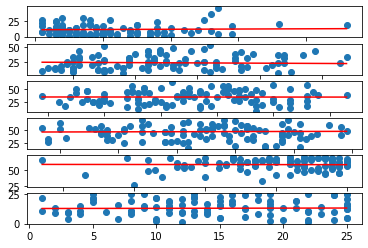

<Figure size 86400x1296 with 0 Axes>

<Figure size 86400x1296 with 0 Axes>

<Figure size 86400x1296 with 0 Axes>

<Figure size 86400x1296 with 0 Axes>

<Figure size 86400x1296 with 0 Axes>

<Figure size 86400x1296 with 0 Axes>

In [34]:

fig, axes = plt.subplots(6)
for i in range(6):
    plt.figure(figsize= (1200, 18))
    axes[i].scatter(X_test.iloc[:,i],ys_test.iloc[:,i])
    Xs = pd.DataFrame(X_test)
    Xs['preds'] = models[i].predict(np.array(X_test.iloc[:,i]).reshape(-1,1))
    Xs.sort_values(Xs.columns[i], inplace=True)
    axes[i].plot(Xs.iloc[:,i], np.array(Xs['preds']).reshape(-1,1), color='red')

The graphs of the scatter plots with the lines of fit is about as expected. The linear regression model is going to predict close to the mean to try and maximize its score.